In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install folium==0.2.1
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.5 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=6781b2eb8c5603e2c277e1369ce0f351b521fce05d5d156761c32289d425d444
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.9 MB/s 


In [3]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 596 kB 60.4 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
     |████████████████████████████████| 362 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 212 kB 50.7 MB/s 
     |████████████████████████████████| 140 kB 56.0 MB/s 
     |████████████████████████████████| 127 kB 57.7 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 144 kB 74.6 MB/s 
     |████████████████████████████████| 271 kB 74.7 MB/s 


In [4]:
import torch
from datasets import load_dataset
import pandas as pd
import collections
from datasets import load_dataset , load_metric
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

In [5]:
dataset = load_dataset("Shayanvsf/ParSQuAD") # two available modes
dataset_eval = load_dataset("Shayanvsf/pquad_public")


Please Enter your desire mode(manual / automatic) :manual


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/97ed8736ab42b51abce02f9a5dcbb958a09b958ed194531ae7f9bb0ff935208b


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/13c29e41def66551bca1fcaed06c03c0939876d6641627d49910939b20e6ab49
Dataset par_s_qu_ad downloaded and prepared to /root/.cache/huggingface/datasets/Shayanvsf___par_s_qu_ad/ParSQuAD/1.0.0/124ac9a0ce7760ed368457a321c510f7c5592f9fa8026e6643cfe3d551b5d0d3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/c398ba29001242851de4d8dc468625e7eeccc2041e8168871e972293b3745bde


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/d87772b342fcc0d549d5a7a63e6b8873e2ae95e5c07919932e587397f545910d


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/e6f3da0212a37e85850d4f58a11a3e7bff446fcd83b57e8aeb54bbafa8ed95c8
Dataset pquad_public downloaded and prepared to /root/.cache/huggingface/datasets/Shayanvsf___pquad_public/pquad_public/1.0.0/20f4f02802eb56c6b1f41e0fd9e4b3452884817ce8592df8fe863576c1569264. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 18906
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5711
    })
})

In [7]:
dataset['train'] = dataset['train'].remove_columns("id")
dataset['validation'] = dataset['validation'].remove_columns("id")

In [8]:
new_column_train = range(0,len(dataset['train']))
dataset['train'] = dataset['train'].add_column('id',new_column_train)
new_column_validation = range(0,len(dataset['validation']))
dataset['validation'] = dataset['validation'].add_column('id',new_column_validation)

#Loading datasets

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'answers', 'id'],
        num_rows: 18906
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'answers', 'id'],
        num_rows: 5711
    })
})

In [10]:
dataset_eval

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 7878
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1157
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 964
    })
})

## Train Data

In [11]:
pd.DataFrame(data = dataset['train']).head()

,title,context,question,answers,id
0,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,از چه زمانی بیانسه شروع به محبوبیت کرد؟,"{'text': ['در اواخر دهه 1990'], 'answer_start'...",0
1,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,چه موقع بیانسه Destiny's Child را ترک کرد و یک...,"{'text': ['2003'], 'answer_start': [476]}",1
2,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,در چه دهه ای بیانسه مشهور شد؟,"{'text': ['اواخر دهه 1990'], 'answer_start': [...",2
3,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,چه کسی گروه Destiny's Child را مدیریت می کرد؟,"{'text': ['ماتیو نولز'], 'answer_start': [323]}",3
4,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,چه موقع بیانسه به شهرت رسید؟,"{'text': ['اواخر دهه 1990'], 'answer_start': [...",4


## Validation Data

In [12]:
pd.DataFrame(data = dataset['validation']).head()

,title,context,question,answers,id
0,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,نرماندی در کدام کشور واقع شده است؟,"{'text': ['فرانسه', 'فرانسه', 'فرانسه', 'فرانس...",0
1,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,نورمن ها چه زمانی در نرماندی بودند؟,"{'text': ['قرون 10 و 11', 'در قرون 10 و 11', '...",1
2,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,نژاد نورس از کدام کشورها است؟,"{'text': ['دانمارک ، ایسلند و نروژ', 'دانمارک ...",2
3,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,چه کسی نام خود را در 1000 و 1100 به نرماندی دا...,"{'text': [], 'answer_start': []}",3
4,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,فرانسه چه منطقه ای است؟,"{'text': [], 'answer_start': []}",4


## Model Init

In [13]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
max_length = 256 #512 # The maximum length of a feature (question and context)
doc_stride = 128 # 256 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 8
lr = 3e-5
epoch = 3

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

In [15]:
tokenizer(".اسمتون چی بود ؟", "اسم من شایان است")

{'input_ids': [2, 15, 58854, 2061, 3069, 2083, 303, 4, 4856, 2078, 9920, 2045, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Create several input features from long contex

In [16]:
for i, example in enumerate(dataset["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        print('Find one')
        break
        
example = dataset["train"][i]

Find one


In [17]:
example

{'answers': {'answer_start': [548], 'text': ['پدر بیانسه']},
 'context': "در هشت سالگی ، بیانسه و دوست دوران کودکی کلی رولند ، در حالی که در یک تست برای یک گروه سرگرمی کاملاً دخترانه بودند ، با لاتاویا رابرسون آشنا شدند. آنها به عنوان Girl's Tyme به همراه سه دختر دیگر در یک گروه قرار گرفتند و در مسابقه استعدادیابی در هوستون رپ و رقصیدند. Arne Frager ، تهیه کننده تحقیق و توسعه ، پس از دیدن گروه ، آنها را به استودیوی کالیفرنیای شمالی خود آورد و در Star Search ، بزرگترین نمایش استعدادهای درخشان تلویزیون ملی آن زمان قرار داد. Girl Tyme نتوانست برنده شود و بعدها بیانسه گفت آهنگی که آنها اجرا کردند خوب نیست. در سال 1995 پدر بیانسه از کار خود برای مدیریت گروه استعفا داد. این اقدام درآمد خانواده بیانسه را به نصف کاهش داد و والدین وی مجبور شدند به آپارتمانهای جداگانه نقل مکان کنند. ماتیو ترکیب اصلی خود را به چهار رساند و گروه به اجرای خود به عنوان اقدامی آغازین برای سایر گروه های دخترانه تحقیق و توسعه ادامه داد. دختران قبل از برچسب های ضبط صدا تست کردند و سرانجام با الکترا رکوردز امضا شدند و مد

In [18]:
len(tokenizer(example["question"], example["context"])["input_ids"])

316

In [19]:
len(tokenizer(example["question"], example["context"], max_length = max_length, truncation="only_second")["input_ids"])

256

## return_overflowing_tokens

In [20]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length = max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [21]:
[len(x) for x in tokenized_example["input_ids"]] 

[256, 205]

In [22]:
len(tokenized_example["input_ids"])

2

In [23]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] در سال [UNK] ، چه کسی تصمیم به مدیریت گروه اواز دختران گرفت ؟ [SEP] در هشت سالگی ، بیانسه و دوست دوران کودکی کلی رولند ، در حالی که در یک تست برای یک گروه سرگرمی کاملا دخترانه بودند ، با لاتاویا رابرسون اشنا شدند. انها به عنوان girl's tyme به همراه سه دختر دیگر در یک گروه قرار گرفتند و در مسابقه استعدادیابی در هوستون رپ و رقصیدند. arne frager ، تهیه کننده تحقیق و توسعه ، پس از دیدن گروه ، انها را به استودیوی کالیفرنیای شمالی خود اورد و در star search ، بزرگترین نمایش استعدادهای درخشان تلویزیون ملی ان زمان قرار داد. girl tyme نتوانست برنده شود و بعدها بیانسه گفت اهنگی که انها اجرا کردند خوب نیست. در سال [UNK] پدر بیانسه از کار خود برای مدیریت گروه استعفا داد. این اقدام درامد خانواده بیانسه را به نصف کاهش داد و والدین وی مجبور شدند به اپارتمانهای جداگانه نقل مکان کنند. ماتیو ترکیب اصلی خود را به چهار رساند و گروه به اجرای خود به عنوان اقدامی اغازین برای سایر گروه های دخترانه تحقیق و توسعه ادامه داد. دختران قبل از برچسب های ضبط صدا تست کردند و سرانجام با الکترا رکوردز امضا شدند و مد

## offset_mapping

In [24]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 2), (3, 6), (7, 11), (12, 13), (14, 16), (17, 20), (21, 26), (27, 29), (30, 36), (37, 41), (42, 46), (47, 53), (54, 58), (58, 59), (0, 0), (0, 2), (3, 6), (7, 12), (13, 14), (15, 21), (22, 23), (24, 28), (29, 34), (35, 40), (41, 44), (45, 50), (51, 52), (53, 55), (56, 60), (61, 63), (64, 66), (67, 69), (70, 73), (74, 78), (79, 81), (82, 86), (87, 93), (94, 99), (101, 108), (109, 114), (115, 116), (117, 119), (120, 123), (123, 127), (128, 132), (132, 135), (136, 140), (141, 145), (145, 146), (147, 151), (152, 154), (155, 160), (161, 165), (165, 166), (166, 167), (168, 170), (170, 172), (173, 175), (176, 181), (182, 184), (185, 189), (190, 194), (195, 197), (198, 200), (201, 205), (206, 210), (211, 217), (218, 219), (220, 222), (223, 229), (230, 241), (242, 244), (245, 251), (252, 254), (255, 256), (257, 263), (263, 264), (264, 265), (266, 268), (268, 270), (271, 274), (274, 277), (278, 279), (280, 284), (285, 290), (291, 296), (297, 298), (299, 304), (305, 306), (307, 309),

In [25]:
len(tokenized_example["offset_mapping"])

2

In [26]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

در در


## return 0 if a token is in the question, else return 1.

In [27]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


## Detecting start and end character of an anwser

In [28]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): # searching in the context
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

140 141


In [29]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

پدر بیانسه
پدر بیانسه


## Putting it all together

In [30]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = f"/content/drive/MyDrive/CA6/checkpoints/{model_name}-finetuned-ParSQuAD",
    overwrite_output_dir = True,
    save_strategy = "steps",
    save_steps = 8000,
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    weight_decay=0.0001)

In [31]:
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    #Assume padding on the right.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,)
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") #extract overflow_to_sample_mapping
    offset_mapping = tokenized_examples.pop("offset_mapping") #extract offset_mapping
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1
            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [32]:
# the datasets library does cashing itself, batched is multitreading for fast-tokenizer
tokenized_ds = dataset.map(prepare_train_features, batched=True, remove_columns=dataset["train"].column_names)

Parameter 'function'=<function prepare_train_features at 0x7f05f6c41320> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [33]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

In [34]:
data_collator = default_data_collator
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer)

In [35]:
# start training
trainer.train()
#trainer.save_model(trainer.save_model("PersianQA(ParsBERT)-trained"))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20562
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7713


Epoch,Training Loss,Validation Loss
1,1.539900,1.704045
2,0.894400,1.845696
3,0.428000,2.691699


***** Running Evaluation *****
  Num examples = 6460
  Batch size = 8
***** Running Evaluation *****
  Num examples = 6460
  Batch size = 8
***** Running Evaluation *****
  Num examples = 6460
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=7713, training_loss=1.040297596398671, metrics={'train_runtime': 3271.7619, 'train_samples_per_second': 18.854, 'train_steps_per_second': 2.357, 'total_flos': 7341429401420616.0, 'train_loss': 1.040297596398671, 'epoch': 3.0})

In [61]:
trainer.save_model("PersianQA(ParsBERT)-trained")

Saving model checkpoint to PersianQA(ParsBERT)-trained
Configuration saved in PersianQA(ParsBERT)-trained/config.json
Model weights saved in PersianQA(ParsBERT)-trained/pytorch_model.bin
tokenizer config file saved in PersianQA(ParsBERT)-trained/tokenizer_config.json
Special tokens file saved in PersianQA(ParsBERT)-trained/special_tokens_map.json


In [64]:
# !cp -r "/content/PersianQA(ParsBERT)-trained/" "/content/drive/MyDrive/CA6/checkpoints/"

# Evaluation

## Trainer output type

In [36]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [37]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [38]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 49,  36,  73,   0,  42, 143,   0,   0], device='cuda:0'),
 tensor([ 49,  39,  77,   0,  42, 146,   0,   0], device='cuda:0'))

## picking the n_best prediction

In [39]:
n_best_size = 20
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

## create validation feature

In [40]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]
    # print(examples["question"])
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [41]:
# validation_features = dataset["validation"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=dataset["validation"].column_names
# )

In [42]:
test_features = dataset_eval["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=dataset_eval["test"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
test_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 995
})

In [44]:
raw_predictions = trainer.predict(test_features)

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 995
  Batch size = 8


In [45]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

## Evaluating model for a single example

In [46]:
max_answer_length = 30
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = test_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = dataset_eval["test"][1]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 11.02133, 'text': 'یک'},
 {'score': 1.2304358, 'text': 'اروپا و همچنین یک'},
 {'score': 0.7450156,
  'text': 'یک قهرمانی در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کوم'},
 {'score': 0.060828686, 'text': 'جام باشگاههای اروپا و همچنین یک'},
 {'score': -0.02584505,
  'text': 'یک قهرمانی در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵'},
 {'score': -1.5514731, 'text': 'همچنین یک'},
 {'score': -1.7996144,
  'text': 'یک قهرمانی در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن'},
 {'score': -3.1561184, 'text': 'یک قهرمانی در'},
 {'score': -8.035114, 'text': '۲۰۰۵ نام آن به کوم'},
 {'score': -8.805975, 'text': '۲۰۰۵'},
 {'score': -9.81674,
  'text': 'اروپا و همچنین یک قهرمانی در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستاد

In [47]:
dataset_eval["test"][1]["answers"]

{'answer_start': [54], 'text': ['یک']}

## feature per example 

In [48]:
# import collections

# examples = dataset["test"]
# features = validation_features

# example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
# features_per_example = collections.defaultdict(list)
# for i, feature in enumerate(features):
#     features_per_example[example_id_to_index[feature["example_id"]]].append(i)

## put it all together

In [49]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = None , max_answer_length = None):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        # if not squad_v2:
        #predictions[example["id"]] = best_answer["text"]
        # else:
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        predictions[example["id"]] = answer

    return predictions

In [50]:
dataset_eval["test"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 964
})

In [51]:
a = [1,2,3]
a.index(1)

0

## Calculating final predictions

In [52]:
c=0
em = np.zeros((9,2))
bs = [10,20,30]
mal = [10,15,20]
fp = []
for b in bs:
  for m in mal:
    fp.append(postprocess_qa_predictions(dataset_eval["test"], test_features, raw_predictions.predictions , b, m))
    em[c,:]=np.array([b,m])
    c+=1

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

In [53]:
metric = load_metric("squad_v2") 

In [54]:
EX = []
F1 = []
for i,pred in enumerate(fp):
  formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in pred.items()] #(method 1)
  # formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()] ##(method 2)
  references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset_eval["test"]]
  print("\n" , metric.compute(predictions=formatted_predictions, references=references))
  EX.append(metric.compute(predictions=formatted_predictions, references=references)['exact'])
  F1.append(metric.compute(predictions=formatted_predictions, references=references)['f1'])


 {'exact': 51.6597510373444, 'f1': 63.96133908315053, 'total': 964, 'HasAns_exact': 48.43110504774898, 'HasAns_f1': 64.609455492711, 'HasAns_total': 733, 'NoAns_exact': 61.904761904761905, 'NoAns_f1': 61.904761904761905, 'NoAns_total': 231, 'best_exact': 51.76348547717842, 'best_exact_thresh': 0.0, 'best_f1': 64.06507352298456, 'best_f1_thresh': 0.0}

 {'exact': 52.0746887966805, 'f1': 64.58790926462069, 'total': 964, 'HasAns_exact': 48.97680763983629, 'HasAns_f1': 65.43348503559946, 'HasAns_total': 733, 'NoAns_exact': 61.904761904761905, 'NoAns_f1': 61.904761904761905, 'NoAns_total': 231, 'best_exact': 52.178423236514526, 'best_exact_thresh': 0.0, 'best_f1': 64.69164370445473, 'best_f1_thresh': 0.0}

 {'exact': 52.28215767634855, 'f1': 64.84156336704802, 'total': 964, 'HasAns_exact': 49.24965893587994, 'HasAns_f1': 65.76707651546296, 'HasAns_total': 733, 'NoAns_exact': 61.904761904761905, 'NoAns_f1': 61.904761904761905, 'NoAns_total': 231, 'best_exact': 52.385892116182575, 'best_exac

In [55]:
np.array(EX)

array([51.65975104, 52.0746888 , 52.28215768, 51.65975104, 52.0746888 ,
       52.28215768, 51.65975104, 52.0746888 , 52.28215768])

In [56]:
df = pd.DataFrame(np.hstack([em , np.array(EX).reshape(-1,1) , np.array(F1).reshape(-1,1)]),columns = ['best_n' , 'max_length','exact','f1'])
df.head()

,best_n,max_length,exact,f1
0,10.0,10.0,51.659751,63.961339
1,10.0,15.0,52.074689,64.587909
2,10.0,20.0,52.282158,64.841563
3,20.0,10.0,51.659751,63.961339
4,20.0,15.0,52.074689,64.587909


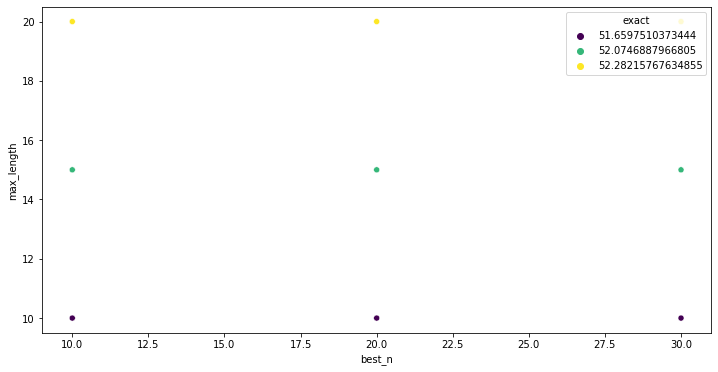

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'exact' , palette = 'viridis')

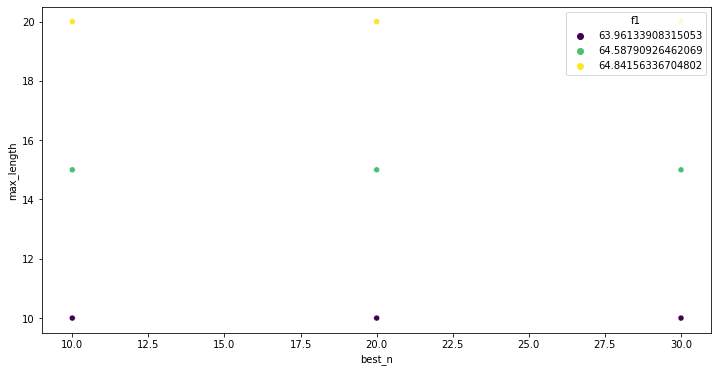

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'f1' , palette = 'viridis')

In [59]:
references[15]

{'answers': {'answer_start': [390], 'text': ['بایرن مونیخ']}, 'id': 1719487.0}

In [60]:
formatted_predictions[15]

{'id': 1719487.0, 'no_answer_probability': 0.0, 'prediction_text': 'بایرن'}